# Capstone Project - The Battle of Neighborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

### 1.1 Background

**Vancouver** is the 8th largest city in **Canada**, which is also called a "city of neighborhoods" because of its ethnic diversity. Also, Vancouver now has one of the highest concentrations of ethnic Chinese people in North America. Other major Asian groups in Vancouver includes South Asian (primarily Punjabi), Indo-Canadian (5.7%), Filipino (5.0%), Japanese (1.7%), Korean (1.5%), Vietnamese, Indonesian, and Cambodian. 

To open up an Asian restaurant is always a popular choice for the first generation Asian immigrants to make a living in a new country. Therefore, finding a right location is crucial to start their business.

### 1.2 Business Problem

This report would be focused on finding a proper neighborhood for Asian immigrants to open up a new restaurant in Vancouver, considering the following factors:
* Safety issue: low crime rate
* Not already crowded with restaurants, especially Asian restaurants

### 1.3 Target Audience

The target audience of this research is the Asian immigrants group who are trying to find a great location to open an Asian restaurant.

## 2.Data <a name="data"></a>

Based on the two factors we considered, we would need the detailed information about:
* Crime rate of all the neighborhood in Vancouver, Canada
* Coordinates of each neighborhood 
* density of existing restaurants in the neighborhood, especially Asian restuarants

To grab all these information and solve the problem, we need to extract what we need from the following resources:
* Crime rate statistics would be obtained from a dataset from Kaggle containing the Vancouver Police Department's crime records from 2013 to 2019, which consists each Neighbourhood in Vancouver along with type of crime, recorded year, month, day, hour and minute, recorded block, GPS. **Dataset URL:** https://www.kaggle.com/agilesifaka/vancouver-crime-report/version/2
* Coordinates of each neighborhood would be catched through **OpenCage Geocoder**
* Density of existing restaurants in the neighborhood, especially Asian restuarants will be obtained using **Foursquare API**

#### Data Cleaning

##### Import Library

In [45]:
import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
('Matplotlib version: ', '2.2.3')
Libraries imported


##### Prepare the Crime Rate Dataset
###### Due to the amount of complete dataset, it was more feasible to grab the statistics from 2018.

In [46]:
vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)
vnc_crime_df.drop(['Unnamed: 0','MINUTE','HUNDRED_BLOCK'], axis=1, inplace=True)
vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2018,3,2,6,West End,491058.816893,5.459123e+06
1,Break and Enter Commercial,2018,6,16,18,West End,491102.243911,5.459092e+06
2,Break and Enter Commercial,2018,12,12,0,West End,490227.222455,5.458210e+06
3,Break and Enter Commercial,2018,4,9,6,Central Business District,490249.230710,5.458167e+06
4,Break and Enter Commercial,2018,10,2,18,Central Business District,490258.682976,5.458155e+06


###### Convert UTM to Longtitude and Latitude system

In [47]:
import math

# utemEasting is X
# utmNorthing is Y
# utmZone is your UTM zone
def utmToLatLong(utmEasting, utmNorthing, utmZone):
    eastingOffset = 500000.0
    northingOffset = 10000000.0
    k0 = 0.9996
    equatorialRadius = 6378137.0
    eccSquared = 0.006694380023
    eccPrimeSquared = eccSquared / (1 - eccSquared)
    e1 = (1 - math.sqrt(1 - eccSquared)) / (1 + math.sqrt(1 - eccSquared));
    rad2deg = 180.0/math.pi

    # Casts input from string to floats or ints
    # Removes 500,000 metre offset for longitude
    xUTM = float(utmEasting) - eastingOffset
    yUTM = float(utmNorthing)
    zoneNumber = int(utmZone)

    # Finds the origin longitude for the zone
    lonOrigin = (zoneNumber - 1) * 6 - 180 + 3 # +3 puts in zone centre

    M = yUTM / k0 #This finds the meridional arc
    mu = M / (equatorialRadius * (1- eccSquared / 4 - 3 * eccSquared * eccSquared / 64 -5 * eccSquared * eccSquared * eccSquared /256))

    # Calculates the footprint latitude
    phi1Rad = mu + (3 * e1 / 2 - 27 * e1 * e1 * e1 /32) * math.sin(2*mu) + ( 21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin( 4 * mu) + (151 * e1 * e1 * e1 / 96) * math.sin(6 * mu)
    phi1 = phi1Rad * rad2deg

    # Variables for conversion equations
    N1 = equatorialRadius / math.sqrt( 1 - eccSquared * math.sin(phi1Rad) *  math.sin(phi1Rad))
    T1 = math.tan(phi1Rad) * math.tan(phi1Rad)
    C1 = eccPrimeSquared * math.cos(phi1Rad) * math.cos(phi1Rad)
    R1 = equatorialRadius * (1 - eccSquared) / math.pow(1 - eccSquared * math.sin(phi1Rad) * math.sin(phi1Rad), 1.5)
    D = xUTM / (N1 * k0)

    # Calculate latitude, in decimal degrees
    lat = phi1Rad - ( N1 * math.tan(phi1Rad) / R1) * (D * D / 2 - (5 + 3 * T1 + 10 * C1 - 4 * C1 * C1 - 9 * eccPrimeSquared) * D * D * D * D / 24 + (61 + 90 * T1 + 298 * C1 + 45 * T1 * T1 - 252 * eccPrimeSquared - 3 * C1 * C1) * D * D * D * D * D * D / 720)
    lat = lat * rad2deg
    
    # Calculate longitude, in decimal degrees
    lon = (D - (1 + 2 * T1 + C1) * D * D * D / 6 + (5 - 2 * C1 + 28 * T1 - 3 * C1 * C1 + 8 * eccPrimeSquared + 24 * T1 * T1) * D * D * D * D * D / 120) / math.cos(phi1Rad)
    lon = lonOrigin + lon * rad2deg
    
    return lon, lat

In [48]:
vnc_crime_df = vnc_crime_df.reset_index(drop=True)
crimes_vancouver_X = vnc_crime_df["X"]
crimes_vancouver_Y = vnc_crime_df["Y"]
longtitude = []
latitude = []
for i in range(len(crimes_vancouver_X)):
    lon, lat = utmToLatLong(crimes_vancouver_X[i], crimes_vancouver_Y[i], 10)
    longtitude.append(lon)
    latitude.append(lat)

In [49]:
vnc_crime_df ["LONGTITUDE"] = longtitude
vnc_crime_df ["LATITUDE"] = latitude
vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD,X,Y,LONGTITUDE,LATITUDE
0,Break and Enter Commercial,2018,3,2,6,West End,491058.816893,5.459123e+06,-123.122946,49.284794
1,Break and Enter Commercial,2018,6,16,18,West End,491102.243911,5.459092e+06,-123.122348,49.284519
2,Break and Enter Commercial,2018,12,12,0,West End,490227.222455,5.458210e+06,-123.134358,49.276572
3,Break and Enter Commercial,2018,4,9,6,Central Business District,490249.230710,5.458167e+06,-123.134055,49.276180
4,Break and Enter Commercial,2018,10,2,18,Central Business District,490258.682976,5.458155e+06,-123.133924,49.276070


In [50]:
vnc_crime_df.drop(['X','Y'], axis=1, inplace=True)
vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD,LONGTITUDE,LATITUDE
0,Break and Enter Commercial,2018,3,2,6,West End,-123.122946,49.284794
1,Break and Enter Commercial,2018,6,16,18,West End,-123.122348,49.284519
2,Break and Enter Commercial,2018,12,12,0,West End,-123.134358,49.276572
3,Break and Enter Commercial,2018,4,9,6,Central Business District,-123.134055,49.276180
4,Break and Enter Commercial,2018,10,2,18,Central Business District,-123.133924,49.276070


In [51]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood','Longtitude','Latitude']
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

##### Create A Dataframe of All the Neighborhood in Vancouver Based on https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver

In [52]:
column_names = ['Neighbourhood', 'Borough'] 

vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

('Total Neighbourhood Count', 24, 'Borough Count', 4)


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


In [53]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')
vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Longtitude,Latitude,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,-123.122946,49.284794,Central
1,Break and Enter Commercial,2018,6,16,18,West End,-123.122348,49.284519,Central
2,Break and Enter Commercial,2018,12,12,0,West End,-123.134358,49.276572,Central
3,Break and Enter Commercial,2018,3,2,3,West End,-123.133889,49.285359,Central
4,Break and Enter Commercial,2018,3,17,11,West End,-123.133889,49.285359,Central


In [54]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

## 3. Methodology <a name="methodology"></a>

In this project, we would focus on finding the proper area in Vancouver considering the safety issue, the density of restaurants, especially Asian restaurants.

**Exploratory Data Analysis**: We would use exploratory data analysis to narrow down our choices based on the crime records of different neighbourhood and present our results through plot and heatmaps. 

**K-Means Clustering**: We would use K-Means clustering based on our consideration of the density of restruarants and especially Asian restuarants, while combine with the power of Foursquare to identify the most proper position to start an Asian restaurant.

## 4. Analysis <a name="analysis"></a>

Visualize the crime rate of each neighborhood in Vancouver

In [55]:
vnc_crime_bor = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_bor

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

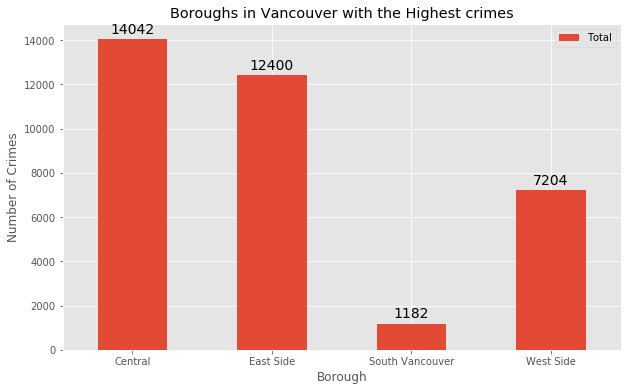

In [56]:
vnc_crime_bor.reset_index(inplace = True)
vnc_crime_bor.columns = vnc_crime_bor.columns.map(''.join)
vnc_crime_bor.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
vnc_crime_bor=vnc_crime_bor.head(4)

per_borough = vnc_crime_bor[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Through the chart, it is clear that South Vancouver borough has the lowest crime records, which is only 8% of the number of the crime cases reported in Central borough, 9.5% of the number of the crime cases reported in East Side. However, South Vancouver has only a few neighborhoods and has already become a district famous of its indian residential neighbourhoods like Punjabi Market. So, we could take West Side into consideration, which owns the records of the second lowest crimes.

In [57]:
vnc_boroughs_crime.head()
vnc_boroughs_crime.loc[vnc_boroughs_crime['Borough']=='West Side']
vnc_WS_crime=vnc_boroughs_crime.loc[vnc_boroughs_crime['Borough']=='West Side']
vnc_WS_crime.reset_index(inplace=True, drop=True)
vnc_WS_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Longtitude,Latitude,Borough
0,Break and Enter Commercial,2018,2,2,17,Shaughnessy,-123.127732,49.250850,West Side
1,Break and Enter Commercial,2018,10,11,19,Shaughnessy,-123.133931,49.237804,West Side
2,Break and Enter Commercial,2018,1,19,17,Shaughnessy,-123.137792,49.245414,West Side
3,Break and Enter Commercial,2018,10,16,18,Shaughnessy,-123.137792,49.245414,West Side
4,Break and Enter Commercial,2018,4,25,17,Shaughnessy,-123.140891,49.240034,West Side


In [58]:
vnc_WS_crime.shape

(7204, 9)

In [59]:
vnc_WS_crime['Neighbourhood'].value_counts()

Kitsilano            1802
Fairview             1795
Marpole               828
Oakridge              499
Dunbar-Southlands     474
Kerrisdale            417
Shaughnessy           414
West Point Grey       372
Arbutus Ridge         311
South Cambie          292
Name: Neighbourhood, dtype: int64

In [60]:
vnc_WS_crime['Type'].value_counts()

Theft from Vehicle                                        2838
Mischief                                                  1062
Break and Enter Residential/Other                         1000
Other Theft                                                696
Theft of Bicycle                                           588
Break and Enter Commercial                                 403
Vehicle Collision or Pedestrian Struck (with Injury)       389
Theft of Vehicle                                           225
Vehicle Collision or Pedestrian Struck (with Fatality)       3
Name: Type, dtype: int64

Since we are considering opening a restaurant, we should pay more attention to the crime type 'Break and Enter Commercial'

In [61]:
vnc_WSBC_crime=vnc_WS_crime.loc[vnc_WS_crime['Type']=='Break and Enter Commercial']
vnc_WSBC_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Longtitude,Latitude,Borough
0,Break and Enter Commercial,2018,2,2,17,Shaughnessy,-123.127732,49.250850,West Side
1,Break and Enter Commercial,2018,10,11,19,Shaughnessy,-123.133931,49.237804,West Side
2,Break and Enter Commercial,2018,1,19,17,Shaughnessy,-123.137792,49.245414,West Side
3,Break and Enter Commercial,2018,10,16,18,Shaughnessy,-123.137792,49.245414,West Side
4,Break and Enter Commercial,2018,4,25,17,Shaughnessy,-123.140891,49.240034,West Side


In [62]:
vnc_WSBC_crime.shape

(403, 9)

Visualize the break and enter commercial crime cases of in West Side

In [63]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done

# All requested packages already installed.

Folium installed and imported!


In [64]:
# Vancouver latitude and longitude values
latitude = 49.25
longitude = -123.12
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [65]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(vnc_WSBC_crime.Latitude, vnc_WSBC_crime.Longtitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
van_map.add_child(incidents)

In [66]:
vnc_WSBC_crime['Neighbourhood'].value_counts()

Fairview             138
Kitsilano            106
Marpole               44
Kerrisdale            24
South Cambie          22
Oakridge              19
West Point Grey       18
Arbutus Ridge         12
Shaughnessy           12
Dunbar-Southlands      8
Name: Neighbourhood, dtype: int64

In [67]:
vnc_WSBC_crime['Neighbourhood'].unique()

array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

In [68]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_WSBC_crime['Neighbourhood'].unique()



key = '9e8dea5e25bc4c3d8361dd50e3200464'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
print(Latitude, Longitude)

([49.2518626, 49.2641128, 49.2308288, 49.2092233, 49.2694099, 49.2346728, 49.2644843, 49.2409677, 49.2466847, 49.2534601], [-123.1380226, -123.1268352, -123.1311342, -123.1361495, -123.155267, -123.1553893, -123.1854326, -123.1670008, -123.120915, -123.1850439])


In [69]:
ws_nei_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_nei_geo = pd.DataFrame(data=ws_nei_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_nei_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


In [70]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(ws_nei_geo.Latitude, ws_nei_geo.Longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

latitudes = list(ws_nei_geo.Latitude)
longitudes = list(ws_nei_geo.Longitude)
labels = list(ws_nei_geo.Neighbourhood)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(van_map)  


for lat, lng, in zip(vnc_WSBC_crime.Latitude, vnc_WSBC_crime.Longtitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
# add incidents to map
van_map.add_child(incidents)

In [71]:
vnc_crime_WSBC = pd.pivot_table(vnc_WSBC_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_WSBC

Year     
Type              Break and Enter Commercial  All
Neighbourhood                                    
Arbutus Ridge                             12   12
Dunbar-Southlands                          8    8
Fairview                                 138  138
Kerrisdale                                24   24
Kitsilano                                106  106
Marpole                                   44   44
Oakridge                                  19   19
Shaughnessy                               12   12
South Cambie                              22   22
West Point Grey                           18   18
All                                      403  403

In [72]:
vnc_crime_WSBC.reset_index(inplace = True)
vnc_crime_WSBC.columns= vnc_crime_WSBC.columns.map(''.join)
vnc_crime_WSBC.rename(columns={'YearAll':'Total'}, inplace=True)
vnc_crime_WSBC.head()

,Neighbourhood,YearBreak and Enter Commercial,Total
0,Arbutus Ridge,12,12
1,Dunbar-Southlands,8,8
2,Fairview,138,138
3,Kerrisdale,24,24
4,Kitsilano,106,106


In [73]:
vnc_crime_WSBC.sort_values(['YearBreak and Enter Commercial'], ascending = False, axis = 0, inplace = True )
vnc_crime_WSBC_low = vnc_crime_WSBC.tail(5)
vnc_crime_WSBC_low

,Neighbourhood,YearBreak and Enter Commercial,Total
6,Oakridge,19,19
9,West Point Grey,18,18
0,Arbutus Ridge,12,12
7,Shaughnessy,12,12
1,Dunbar-Southlands,8,8


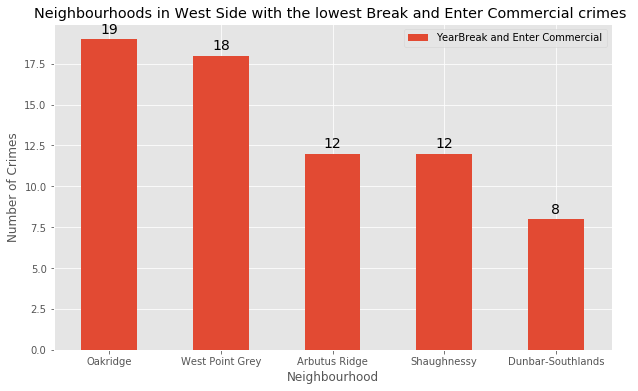

In [74]:
per_neigh = vnc_crime_WSBC_low[['Neighbourhood','YearBreak and Enter Commercial']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in West Side with the lowest Break and Enter Commercial crimes ')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

From the analysis we had done above, we have narrowed our choices down to 10 neighborhoods in West side. Among these 10 neighborhoods, Dunbar-Southlands, Shaughnessy, Arbutus Ridge, West Point Grey and Oakridge have the relatively low records in break and enter commercials crime. Then we would take the density of restaurants into consideration.

In [75]:
ws_nei_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


In [76]:
ws_nei_geo.to_pickle('./locations.pkl')    

In [77]:
#Four Square Credentials
CLIENT_ID = 'XK0M2MXMVEOJNRG5K52ZQGDJNVSB4L5T0SDPQCT4QNYJYLKA' # your Foursquare ID
CLIENT_SECRET = 'X5PNBBOQEAOWBIIN0TN4TXNYGGKTLOHUJKATAXIMQQREQUTG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XK0M2MXMVEOJNRG5K52ZQGDJNVSB4L5T0SDPQCT4QNYJYLKA
CLIENT_SECRET:X5PNBBOQEAOWBIIN0TN4TXNYGGKTLOHUJKATAXIMQQREQUTG


In [82]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:
WS_venues = getNearbyVenues(names=ws_nei_geo['Neighbourhood'],
                                   latitudes=ws_nei_geo['Latitude'],
                                   longitudes=ws_nei_geo['Longitude']
                                  )

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands


In [91]:
print(WS_venues.shape)
WS_venues.head()

(226, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Shaughnessy,49.251863,-123.138023,Angus Park,49.254833,-123.139232,Park
1,Shaughnessy,49.251863,-123.138023,Crepe & Cafe,49.249507,-123.143677,French Restaurant
2,Fairview,49.264113,-123.126835,Gyu-Kaku Japanese BBQ,49.263362,-123.125534,BBQ Joint
3,Fairview,49.264113,-123.126835,CRESCENT nail and spa,49.263317,-123.128044,Nail Salon
4,Fairview,49.264113,-123.126835,Finlandia Pharmacy,49.263510,-123.129227,Pharmacy


In [92]:
WS_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbutus Ridge,4,4,4,4,4,4
Dunbar-Southlands,7,7,7,7,7,7
Fairview,26,26,26,26,26,26
Kerrisdale,36,36,36,36,36,36
Kitsilano,47,47,47,47,47,47
Marpole,30,30,30,30,30,30
Oakridge,10,10,10,10,10,10
Shaughnessy,2,2,2,2,2,2
South Cambie,16,16,16,16,16,16


In [93]:
print('There are {} uniques categories.'.format(len(WS_venues['Venue Category'].unique())))

There are 87 uniques categories.


##### Analyze each neighborhood in West Side

In [96]:
# one hot encoding
WS_onehot = pd.get_dummies(WS_venues[['Venue Category']], prefix="", prefix_sep="")
WS_onehot.insert(loc=0, column='Neighborhood', value=WS_venues['Neighborhood'] )
WS_onehot.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fairview,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
WS_grouped=WS_onehot.groupby('Neighborhood').mean().reset_index()
WS_grouped

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dunbar-Southlands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,0.000000,0.000000,0.076923,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000
3,Kerrisdale,0.000000,0.000000,0.027778,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,...,0.000000,0.055556,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000
4,Kitsilano,0.042553,0.000000,0.021277,0.000000,0.063830,0.000000,0.000000,0.021277,0.000000,...,0.000000,0.021277,0.021277,0.042553,0.000000,0.021277,0.000000,0.000000,0.000000,0.021277
5,Marpole,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000
6,Oakridge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
7,Shaughnessy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,South Cambie,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,West Point Grey,0.000000,0.020833,0.020833,0.000000,0.041667,0.020833,0.020833,0.000000,0.041667,...,0.000000,0.000000,0.000000,0.000000,0.020833,0.041667,0.000000,0.020833,0.020833,0.020833


##### Print each neighborhood along with the top 5 most common venues

In [100]:
num_top_venues = 5

for hood in WS_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = WS_grouped[WS_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
            venue  freq
0  Nightlife Spot  0.25
1          Bakery  0.25
2   Grocery Store  0.25
3             Spa  0.25
4            Park  0.00


----Dunbar-Southlands----
                 venue  freq
0         Liquor Store  0.14
1    Indian Restaurant  0.14
2          Coffee Shop  0.14
3  Sporting Goods Shop  0.14
4       Ice Cream Shop  0.14


----Fairview----
                 venue  freq
0          Coffee Shop  0.15
1     Asian Restaurant  0.08
2                 Park  0.08
3  Japanese Restaurant  0.04
4     Sushi Restaurant  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.11
1  Chinese Restaurant  0.08
2      Sandwich Place  0.06
3    Sushi Restaurant  0.06
4            Pharmacy  0.06


----Kitsilano----
                 venue  freq
0               Bakery  0.06
1  American Restaurant  0.04
2          Coffee Shop  0.04
3      Thai Restaurant  0.04
4     Sushi Restaurant  0.04


----Marpole----
                venue  freq
0    Sushi

##### Create the new dataframe and display the top 10 venues for each neighborhood.

In [101]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = WS_grouped['Neighborhood']

for ind in np.arange(WS_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(WS_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Spa,Grocery Store,Bakery,Nightlife Spot,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner
1,Dunbar-Southlands,Indian Restaurant,Liquor Store,Ice Cream Shop,Sushi Restaurant,Sporting Goods Shop,Coffee Shop,Italian Restaurant,Grocery Store,Cosmetics Shop,Deli / Bodega
2,Fairview,Coffee Shop,Asian Restaurant,Park,Japanese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Malay Restaurant,Diner
3,Kerrisdale,Coffee Shop,Chinese Restaurant,Sandwich Place,Pharmacy,Tea Room,Sushi Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Convenience Store,Noodle House
4,Kitsilano,Bakery,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Food Truck,French Restaurant,Ice Cream Shop,Restaurant,American Restaurant,Thai Restaurant


##### Cluster Neighborhood

In [111]:
# set number of clusters
kclusters = 4

WS_grouped_clustering = WS_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(WS_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [113]:
# add clustering labels

ws_nei_geo.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
WS_merged = ws_nei_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
WS_merged = WS_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

WS_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,1,Park,French Restaurant,Yoga Studio,Food,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Asian Restaurant,Park,Japanese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Malay Restaurant,Diner
2,Oakridge,West Side,49.230829,-123.131134,0,Sporting Goods Shop,Food,Pharmacy,Café,Park,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Convenience Store,Vietnamese Restaurant
3,Marpole,West Side,49.209223,-123.136150,0,Sushi Restaurant,Dessert Shop,Chinese Restaurant,Pizza Place,Bus Stop,Japanese Restaurant,Sandwich Place,Gas Station,Liquor Store,Falafel Restaurant
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Food Truck,French Restaurant,Ice Cream Shop,Restaurant,American Restaurant,Thai Restaurant


##### Visualize the resulting clusters

In [120]:
from geopy.geocoders import Nominatim 
address = 'Vancouver, CA'

geolocator = Nominatim(user_agent="Vancouver_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


In [121]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(WS_merged['Latitude'], WS_merged['Longitude'], WS_merged['Neighborhood'], WS_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Examine Clusters

##### Cluster 1

In [122]:
WS_merged.loc[WS_merged['Cluster Labels'] == 0, WS_merged.columns[[1] + list(range(5, WS_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Side,Coffee Shop,Asian Restaurant,Park,Japanese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Malay Restaurant,Diner
2,West Side,Sporting Goods Shop,Food,Pharmacy,Café,Park,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Convenience Store,Vietnamese Restaurant
3,West Side,Sushi Restaurant,Dessert Shop,Chinese Restaurant,Pizza Place,Bus Stop,Japanese Restaurant,Sandwich Place,Gas Station,Liquor Store,Falafel Restaurant
4,West Side,Bakery,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Food Truck,French Restaurant,Ice Cream Shop,Restaurant,American Restaurant,Thai Restaurant
5,West Side,Coffee Shop,Chinese Restaurant,Sandwich Place,Pharmacy,Tea Room,Sushi Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Convenience Store,Noodle House
6,West Side,Coffee Shop,Japanese Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Bookstore,Bus Station,Pub,Sushi Restaurant,Pizza Place


##### Cluster 2

In [123]:
WS_merged.loc[WS_merged['Cluster Labels'] == 1, WS_merged.columns[[1] + list(range(5, WS_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Side,Park,French Restaurant,Yoga Studio,Food,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant


##### Cluster 3

In [124]:
WS_merged.loc[WS_merged['Cluster Labels'] == 2, WS_merged.columns[[1] + list(range(5, WS_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,West Side,Spa,Grocery Store,Bakery,Nightlife Spot,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner


##### Cluster 4

In [125]:
WS_merged.loc[WS_merged['Cluster Labels'] == 3, WS_merged.columns[[1] + list(range(5, WS_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,West Side,Indian Restaurant,Liquor Store,Ice Cream Shop,Sushi Restaurant,Sporting Goods Shop,Coffee Shop,Italian Restaurant,Grocery Store,Cosmetics Shop,Deli / Bodega


Based on the result of K-means Clustering, we divide all the neighborhoods in West side into four clusters. We could see in Cluster 1, those neighborhoods are crowded with various restaurants, coffee shops and bakery. Above that, different types of Chinese restaurants also ranked really high in this cluster, like Asian restaurant, Japanese restaurant, Chinese restaurant. In Cluster 4, Indian restaurant is the first most common venue, which also means it might not be a good option for us to go for. On the contrast, Cluster 2&3 meet our expectation of not being already crowded with restaurants, especially Asian restaurants.    

## 5. Results and Discussion <a name="results"></a>

To consider the safety issue, we use the crime records the crime rate of all the neighborhood in Vancouver, Canada from 2018. Through the Exploratory Data Analysis, we successfully lockdown the West Side borough. Even though it is not the borough have the fewest cases, it owns the records of the second lowest crimes and has more neighborhoods compared to South Vancouver borough, who has the lowest crimes. Above that, through the exploration of  the break and enter commercial statistics by neighborhood in West Side, we come up with the result that among all 10 neighborhoods, Dunbar-Southlands, Shaughnessy, Arbutus Ridge, West Point Grey and Oakridge have the relatively low records in break and enter commercials crime.

With the help of Foursquare API and OpenCage API, we’re able to use K-Means Clustering to cluster 10 neighborhoods into four clusters. Through examining each cluster, we find out the Cluster 2- Shaughnessy and Cluster 3- Arbutus Ridge are outstanding in the relatively low density of restaurants, especially Asian restaurants.

Combining the safety issue and the density of restaurants, Shaughnessy and Arbutus Ridge, these two neighborhoods both perform well. 


## 6. Conclusion <a name="conclusion"></a>

Since the purpose of this report is to find a proper neighborhood for Asian immigrants to open up a new restaurant in Vancouver, Shaughnessy and Arbutus Ridge would be the top two choices to recommend based on the crime records and the density of existing restaurants and Asian restaurants.

However, the limitation of this research also need to be taken into consideration. Since, we didn’t have the population distribution statistics, the low crimes records might mean low residence population or low traffic. Also, the low density of restaurants might also mean low traffic during meal times. 
